In [36]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io
from scipy import interpolate
from scipy import ndimage

# Import "local" packages
import hyspec_io
import image_render

In [2]:
#%% Paths
input_file = '/mnt/datadisk/Massimal/20210825_Olbergholmen/08-25/OlbergholmenN-13/OlbergholmenN_Pika_L_13.bil.hdr'
output_file = '/mnt/datadisk/Massimal/Tmp/Test_Interpolate/OlbergholmenN_Pika_L_13.bil.hdr'

In [3]:
#%% Import data
(im_cube,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(input_file)

In [4]:
#%% Detect saturation
print(im_cube.max())
print(2**12 - 1)

4095.0
4095


In [31]:
sat_val = 2**12 - 1
sat_pix_mask = np.any(im_cube == sat_val,axis=2)

<function matplotlib.pyplot.draw()>

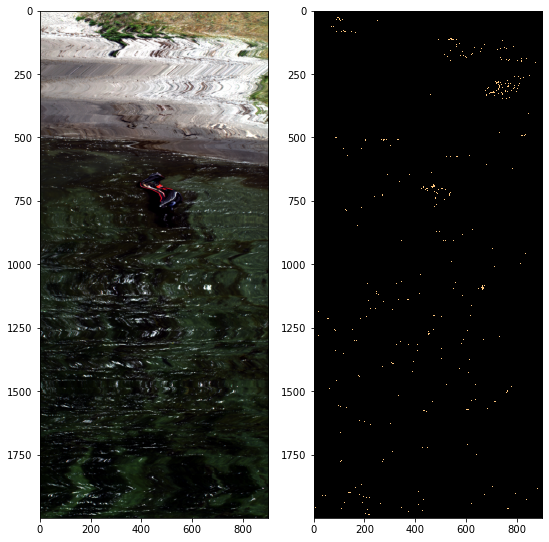

In [16]:
fig,ax = plt.subplots(ncols=2,figsize=(9,12))
ax[0].imshow(image_render.percentile_stretch(im_cube[:,:,rgb_ind],(2,98),separate_bands=True))
ax[1].imshow(sat_pix_mask,interpolation='none',cmap='copper')

In [17]:
#%% Interpolate for saturated pixels
from skimage.restoration import inpaint

In [19]:
#%% Inpainting - this is VERY slow
im_interp = inpaint.inpaint_biharmonic(im_cube[:,:,rgb_ind],sat_pix_mask,multichannel=True)

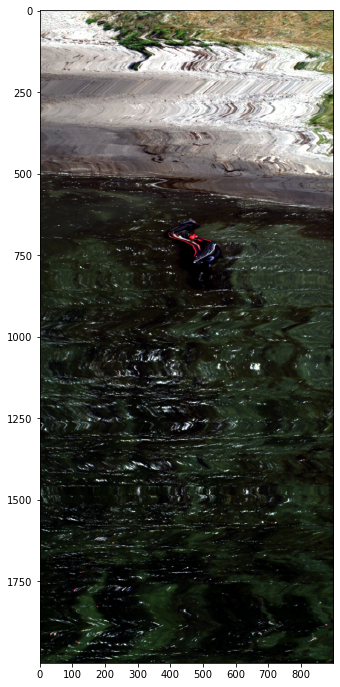

In [27]:
fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(image_render.percentile_stretch(im_interp,(2,98),separate_bands=True))

In [28]:
#%% Alternative, but opencv is hard to install
#import cv2 
#dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)


In [61]:
#%% Interpolate with griddata (only works on single-band data!)
x = np.arange(0, im_cube.shape[1])
y = np.arange(0, im_cube.shape[0])
xx, yy = np.meshgrid(x, y)

    
#mask invalid values
#get only the valid values
x_valid = xx[~sat_pix_mask]
y_valid = yy[~sat_pix_mask]

x_invalid = xx[sat_pix_mask]
y_invalid = yy[sat_pix_mask]

val_valid = im_cube[~sat_pix_mask]



In [72]:
#%% This takes multiple seconds for a single band. Slow...!
# Also, the function doesn't quite do what we need. We only need to fill in maybe 1% of the 
# image, while this seems to interpolate _all_ the points, also the ones which don't need
# interpolation
points = im_cube[:,:,100]
points = points[~sat_pix_mask]
points = points.ravel()
GD1 = interpolate.griddata((x_valid, y_valid),points,(xx, yy),method='linear')

In [73]:
#%% Bivariate spline? Doesn't allow missing data (it seems)
from scipy.interpolate import RectBivariateSpline
interp_spline = RectBivariateSpline(y, x, im_cube)

In [68]:
points.shape

(1800000,)

In [38]:
from scipy.ndimage.interpolation import map_coordinates
import numpy as np


in_data = np.array([[0., -1., 2.],
                    [2., 1., 0.],
                    [4., 3., 2.]])  # z = 2.*x - 1.*y

# want the second argument as a column vector (or a transposed row)
# see on some points of the grid:
print('at the point 0, 0 of the grid the function z is: ')
print(map_coordinates(in_data, np.array([[0., 0.]]).T, order=1))
print('at the point 0, 1 of the grid the function z is: ')
print(map_coordinates(in_data, np.array([[0., 1.]]).T, order=1))
print('at the point 0, 2 of the grid the function z is: ')
print(map_coordinates(in_data, np.array([[0., 2.]]).T, order=1))

# see some points outside the grid
print()
print('at the point 0.2, 0.2 of the grid, with linear interpolation z is:')
print(map_coordinates(in_data, np.array([[.2, .2]]).T, order=1))
print('and it coincides with 2.*.2 - .2')
print()
print('at the point 0.2, 0.2 of the grid, with cubic interpolation z is:')
print(map_coordinates(in_data, np.array([[0.2, .2]]).T, order=3))

at the point 0, 0 of the grid the function z is: 
[0.]
at the point 0, 1 of the grid the function z is: 
[-1.]
at the point 0, 2 of the grid the function z is: 
[2.]

at the point 0.2, 0.2 of the grid, with linear interpolation z is:
[0.2]
and it coincides with 2.*.2 - .2

at the point 0.2, 0.2 of the grid, with cubic interpolation z is:
[-0.03232]


In [59]:
#%% Try map_coordinates() - think this genrates too big arrays
input_im = im_cube[:,:,rgb_ind]

x = np.arange(im_cube.shape[1])
y = np.arange(im_cube.shape[0])
b = np.arange(im_cube.shape[2])
xx, yy = np.meshgrid(x, y, b)

input_im = np.reshape(input_im,(input_im.shape[0]*input_im.shape[1],input_im.shape[2]))

ValueError: too many values to unpack (expected 2)

In [53]:
#mask invalid values
#get only the valid values
#x_valid = xx[~sat_pix_mask]
#y_valid = yy[~sat_pix_mask]
val_valid = im_cube[~sat_pix_mask]
x_invalid = xx[sat_pix_mask]
y_invalid = yy[sat_pix_mask]

coordinates = np.array([x_invalid.ravel(),y_invalid.ravel()])

print(coordinates.shape[0])
print(input_im.ndim)
#in_im = im_cube[:,:,rgb_ind]


tmp = map_coordinates(input_im,coordinates)

2
2


In [58]:
np.arange(3)

array([0, 1, 2])

In [56]:
coordinates.shape

(2, 5539)

In [55]:
input_im.shape

(1800000, 3)

In [48]:
tmp = np.reshape(im_cube,(im_cube.shape[0]*im_cube.shape[1],im_cube.shape[2]))

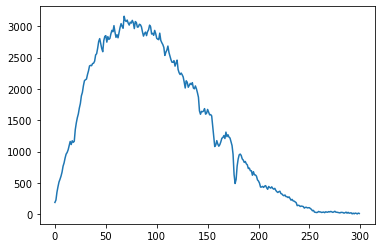

In [51]:
plt.plot(tmp[1,:])

In [ ]:
#%% Seems that it is possible to interpolate masked data with interp2d
# See https://stackoverflow.com/questions/35807321/scipy-interpolation-with-masked-data
# Since bands should be interpolated independently (I think), interp2d() 
# applied to each band in a for loop is better than interpn(). 